# Table of Contents
 <p>

In [1]:
from ipyparallel import Client

cl = Client()

cl.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [2]:
%%px --local

# run whole cell on all engines a well as in the local IPython session

import numpy as np

import sys

sys.path.insert(0, '/home/claudius/Downloads/dadi')

import dadi

In [3]:
%ll dadiExercises/

total 33676
lrwxrwxrwx 1 claudius       53 Feb 17 15:37 ERY.FOLDED.sfs -> /data3/claudius/Big_Data/ANGSD/SFS/ERY/ERY.FOLDED.sfs
-rw-rw-r-- 1 claudius      499 Mar 24 14:04 ERY.FOLDED.sfs.dadi_format
-rw-rw-r-- 1 claudius      499 Mar 24 14:02 ERY.FOLDED.sfs.dadi_format~
lrwxrwxrwx 1 claudius       37 Feb 18 17:46 EryPar.unfolded.2dsfs -> ../../ANGSD/FST/EryPar.unfolded.2dsfs
-rw-rw-r-- 1 claudius    13051 Feb 18 19:00 EryPar.unfolded.2dsfs.dadi_format
-rw-rw-r-- 1 claudius    13051 Feb 18 18:31 EryPar.unfolded.2dsfs.dadi_format~
drwxrwxr-x 5 claudius     4096 Feb 17 13:45 examples/
-rw-rw-r-- 1 claudius   155251 Mar 22 12:37 example_YRI_CEU.ipynb
-rw-rw-r-- 1 claudius   619699 Apr 20 10:19 First_Steps_with_dadi.ipynb
-rw-rw-r-- 1 claudius     1012 Mar 16 09:54 new.bib
lrwxrwxrwx 1 claudius       53 Feb 17 15:37 PAR.FOLDED.sfs -> /data3/claudius/Big_Data/ANGSD/SFS/PAR/PAR.FOLDED.sfs
-rw-rw-r-- 1 claudius      486 Mar 24 20:08 PAR.FOLDED.sfs.dadi_format
-rw-rw-r-- 1 claudius      450 Mar

In [4]:
%less dadiExercises/EryPar.unfolded.2dsfs.dadi_format

In [5]:
# import 2D unfolded spectrum

sfs2d_unfolded = dadi.Spectrum.from_file('dadiExercises/EryPar.unfolded.2dsfs.dadi_format')

In [23]:
%page sfs2d_unfolded

In [7]:
sfs2d_unfolded.sample_sizes

array([36, 36])

In [8]:
# add population labels
sfs2d_unfolded.pop_ids = ["ery", "par"]

For the estimation of the 2D SFS, `realSFS` has only taken sites that had data from at least 9 individuals in *each* population (see `assembly.sh`, lines 1423 onwards).

In [9]:
sfs2d_unfolded.S()

60573.584426000001

The 2D spectrum contains counts from 60k sites that are variable in *par* or *ery* or both.

In [10]:
import pylab

%matplotlib inline

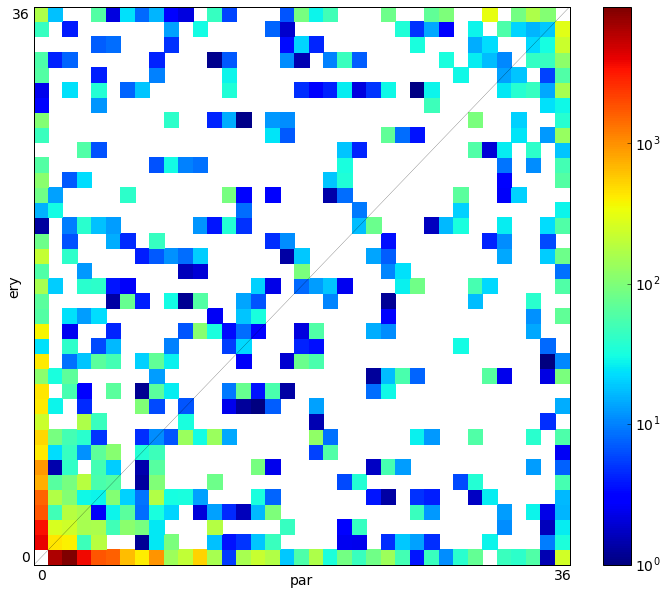

In [22]:
# note this needs to be in the same cell as the dadi plotting function call to take effect
pylab.rcParams['font.size'] = 14.0
pylab.rcParams['figure.figsize'] = [12.0, 10.0]

dadi.Plotting.plot_single_2d_sfs(sfs2d_unfolded, vmin=1, cmap=pylab.cm.jet)

In [24]:
%psource dadi.Plotting.plot_single_2d_sfs

[More colormaps](http://www.scipy-lectures.org/intro/matplotlib/index.html#colormaps)

In [26]:
sfs2d_folded = sfs2d_unfolded.fold()

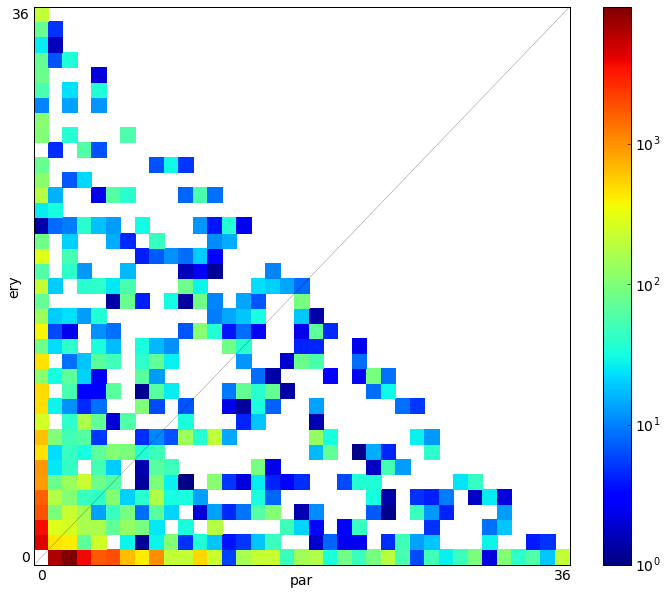

In [27]:
# plot the folded GLOBAL minor allele frequency spectrum

dadi.Plotting.plot_single_2d_sfs(sfs2d_folded, vmin=1, cmap=pylab.cm.jet)

In [43]:
# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [40, 50, 60]

The fitting of parameters for various 1D models to the SFS's of _par_ and _ery_ has indicated the following:
- _ery_ has undergone a population size increase by >20 fold (between about 1-2 $\times2N_{ref}$ generations ago) and later (<1 $\times2N_{ref}$ generations ago) a decrease to about 15% of the ancient populations size
- _par_ has undergone only one size change to <10% of the ancient population size, this is inferred to have happened in the distant past, about 2-4 ($\times 2N_{ref}$) generations ago

I think it would be good to incorporate this information in the specification of a more complex 2D model.

In [36]:
%pinfo dadi.Demographics2D.split_mig

There are a couple of built-in models that I could use, but I think I need a custom model here that includes the information from the 1D model fitting.

I would like to write a model function that specifies an ancient split between _ery_ and _par_, then a population decline in _par_ that lasts until the present and later an exponential growth in _ery_ that is more recently followed by a population decline.

An alternative model to test would be a population decline in the ancestral population, followed by the split between, later population increase in ery which is more recently followed by a population decline.

In [49]:
def split_1grow_2decline_1decline_nomig((nu1s, nu2s, nu2f, nu1b, nu1f, Ts, T2, Tb, Tf), (n1, n2), pts):
    """
    model function: specifies an ancient split, followed by growth in pop1 and 
                    decline in pop2, later also decline in pop1
    
    nu1s: rel. size of pop1 after split
    nu2s: rel. size of pop2 after split
    nu2f: final rel. size for pop2
    nu1b: rel. size of pop1 after first size change
    nu1f: final rel. size of pop1
    Ts: time betweem population split and size change in pop2
    T2: time between size change in pop2 and first size change in pop1
    Tb: time between first and second size change in pop1
    Tf: time between second size change in pop1 and present
    
    The population split happend Tf+Tb+T2+Ts (x2N) generations in the past.
    
    n1,n2: sample sizes
    pts: number of grid points to use in extrapolation
    """
    
    # define grid
    xx = yy = dadi.Numerics.default_grid(pts)
    
    # phi for the equilibrium ancestral pop
    phi = dadi.PhiManip.phi_1D(xx)
    
    # population split into pop1 and pop2
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)
    
    # stepwise change in size for pop1 and pop2 after split
    phi = dadi.Integration.two_pops(phi, xx, Ts, nu2=nu2s, nu1=nu1s, m12=0, m21=0)
    # stepwise change in size for pop2 only
    phi = dadi.Integration.two_pops(phi, xx, T2, nu2=nu2f, nu1=nu1s, m12=0, m21=0)
    # stepwise change in size for pop1 only
    phi = dadi.Integration.two_pops(phi, xx, Tb, nu2=nu2f, nu1=nu1b, m12=0, m21=0)
    # stepwise change in size for pop1 only
    phi = dadi.Integration.two_pops(phi, xx, Tf, nu2=nu2f, nu1=nu1f, m12=0, m21=0)
    
    # calculate spectrum
    sfs = dadi.Spectrum.from_phi(phi, (n1, n2), (xx, yy))
    return sfs

I wonder which population dadi assumes to be pop1. In the `sfs2d` spectrum object, _ery_ is pop1 and _par_ is pop2.

In [39]:
?dadi.PhiManip.phi_1D_to_2D

In [50]:
# create link to function that specifies the model
func = split_1grow_2decline_1decline_nomig

# create extrapolating version of the model function
func_ex = dadi.Numerics.make_extrap_log_func(func)

In [44]:
?split_1grow_2decline_1decline_nomig

In [87]:
nu1s = 0.5
nu2s = 0.5
nu2f = 0.05
nu1b = 40
nu1f = 0.15
Ts = 0.1
T2 = 0.1
Tb = 0.1
Tf = 0.1

In [45]:
sfs2d_folded.sample_sizes

array([36, 36])

In [88]:
model_spectrum = func_ex((nu1s, nu2s, nu2f, nu1b, nu1f, Ts, T2, Tb, Tf), sfs2d_folded.sample_sizes, pts_l)

In [89]:
theta = dadi.Inference.optimal_sfs_scaling(model_spectrum.fold(), sfs2d_folded)

In [90]:
theta

22521.516493041683

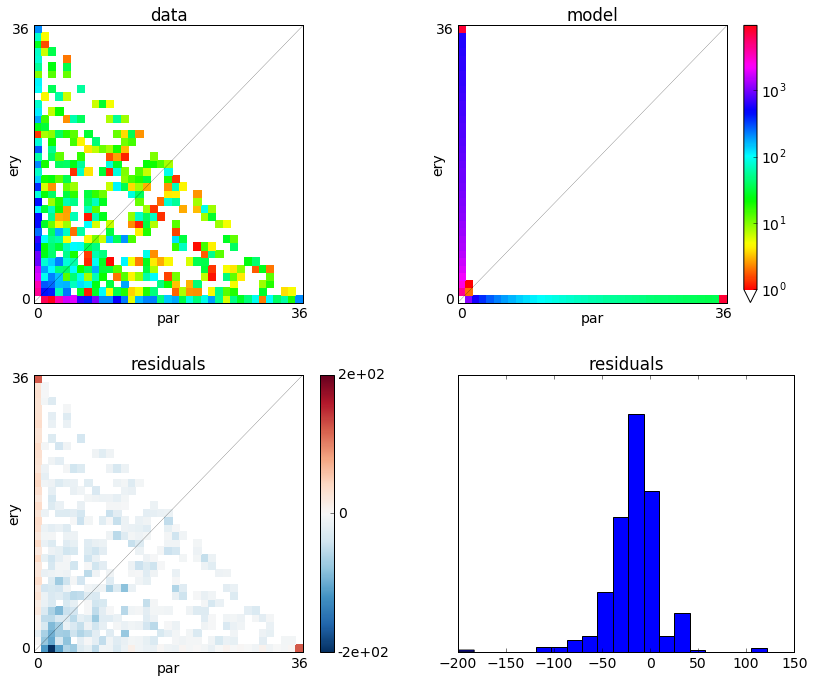

In [91]:
dadi.Plotting.plot_2d_comp_multinom(model_spectrum.fold(), sfs2d_folded, vmin=1)

I think this indicates that I need to allow the split to be more recent.